**Problem statement:** To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

In [ ]:
# Importing all the important libraries
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, MaxPool2D, Flatten

In [ ]:
## If you are using the data by mounting the google drive, use the following :
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# Defining the path for train and test images
#Updating the paths of the train and test dataset
root_path = '/content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration'
train_path = pathlib.Path(root_path + '/Train')
test_path = pathlib.Path(root_path + '/Test')
train_dir = pathlib.Path(train_path)
test_dir = pathlib.Path(test_path)

In [ ]:
# Count of images in train directory and test directory
train_count = len(list(train_dir.glob('*/*.jpg')))
print(train_count)
test_count = len(list(test_dir.glob('*/*.jpg')))
print(test_count)

2248
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [ ]:
# define batch size, image width & height in varibales
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [ ]:
## Writing train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(train_dir, seed = 123, validation_split = 0.2,
                                                              image_size = (img_height, img_width),
                                                              subset = 'training',
                                                              batch_size = batch_size,
                                                              color_mode = 'rgb')

Found 2248 files belonging to 9 classes.
Using 1799 files for training.


In [ ]:
## Writing validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(train_dir, seed=123, validation_split=0.2,
                                                            image_size = (img_height, img_width),
                                                            subset='validation',
                                                            batch_size = batch_size,
                                                            color_mode = 'rgb')

Found 2248 files belonging to 9 classes.
Using 449 files for validation.


In [ ]:
# List out all the classes of skin cancer and store them in a list. 
# the class names in the class_names attribute on these datasets. 
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
class_names

['actinic keratosis',
 'basal cell carcinoma',
 'dermatofibroma',
 'melanoma',
 'nevus',
 'pigmented benign keratosis',
 'seborrheic keratosis',
 'squamous cell carcinoma',
 'vascular lesion']

In [ ]:
#randomly selecting one of class to image variable
image = plt.imread((list(train_dir.glob(class_names[6] + '/*.jpg'))[0]))

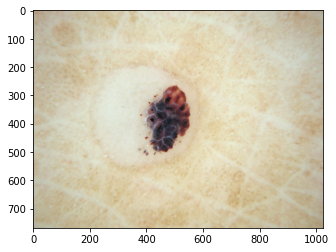

In [ ]:
#plotting the image of image variable
plt.imshow(image)

### Visualize the data
#### Creating a code to visualize one instance of all the nine classes present in the dataset

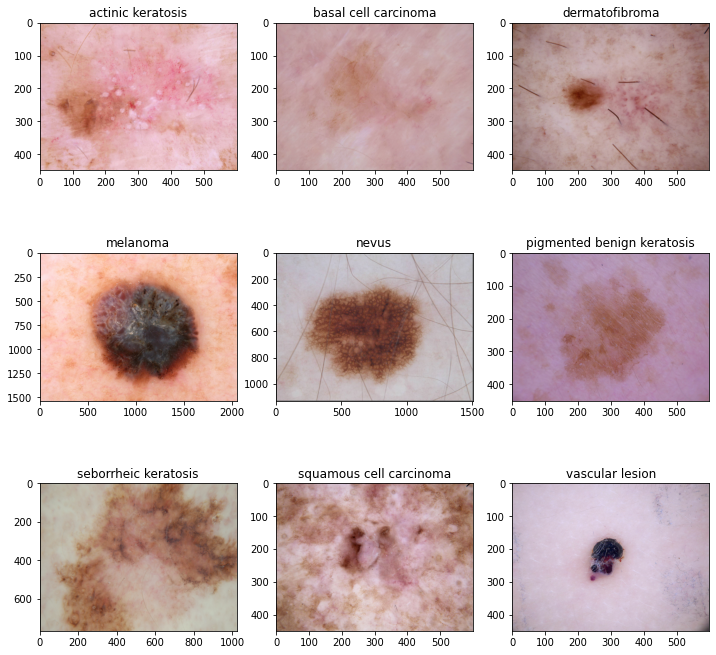

In [ ]:
### using training or validation data to visualize

plt.figure(figsize=(12,12))
for i in range(9):
  plt.subplot(3, 3, i+1)
  image= plt.imread(str(list(train_dir.glob(class_names[i]+'/*.jpg'))[1]))
  plt.title(class_names[i])
  plt.imshow(image)

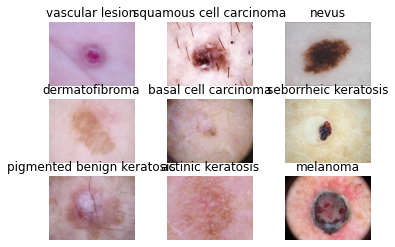

In [ ]:
i = 0
for dirpath, dirnames, filenames in os.walk(str(train_path)):
  for filename in [name for name in filenames if name.endswith(".jpg")][:1]:
    if i <= 8:
      img = PIL.Image.open(str(dirpath) + "/" + str(filename))
      plt.subplot(3, 3, i + 1)
      plt.title(str(dirpath).split('/')[-1])
      plt.axis('off')
      plt.imshow(img)
      i = i + 1

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

# Model Building

### Create the model

- Input to the network is an image of dimensions (180, 180, 3).
- first two layers have 32 channels of a 3*3 filter size and the same padding.
- The Max pool layer of stride (2, 2),
- All hidden layers use ReLU as its activation function as it is more computationally efficient.
- flatten this output. After this there is a fully connected layer. which is used to implement softmax function to classify 9 classes.
- We use Dropout of 0.2 is used to minimise the overfitting.

In [ ]:
# code goes here
model = Sequential([tf.keras.layers.experimental.preprocessing.Rescaling(1/255,
                                                                       input_shape=(180, 180, 3),
                                                                       offset=0.0)])

model.add(Conv2D(filters=32, kernel_size= (3,3), activation='relu', padding='same', input_shape=(180, 180, 3)))
model.add(Conv2D(filters=32, kernel_size=(3,3), activation='relu', padding='same'))
model.add(MaxPool2D(pool_size = (2,2)))
model.add(Dropout(0.2))

model.add(Conv2D(filters=32, kernel_size=(3,3), activation='relu', padding='same'))
model.add(MaxPool2D(pool_size = (2,2)))
model.add(Dropout(0.2))

model.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding='same'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.2))

model.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding='same'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.2))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(9, activation='softmax'))

### Compile the model
Choose an appropirate optimiser and loss function for model training 

In [ ]:
### choosing an appropirate optimiser and loss function
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True),
              metrics=['accuracy'])

In [ ]:
# View the summary of all layers
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_3 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_10 (Conv2D)          (None, 180, 180, 32)      896       
                                                                 
 conv2d_11 (Conv2D)          (None, 180, 180, 32)      9248      
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 90, 90, 32)       0         
 2D)                                                             
                                                                 
 dropout_10 (Dropout)        (None, 90, 90, 32)        0         
                                                                 
 conv2d_12 (Conv2D)          (None, 90, 90, 32)        9248      
                                                      

- Total params: 1,067,337
- Trainable params: 1,067,337
- Non-trainable params: 0

### Train the model

In [ ]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20


/usr/local/lib/python3.8/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


57/57 [==============================] - 19s 117ms/step - loss: 2.0597 - accuracy: 0.2129 - val_loss: 2.0302 - val_accuracy: 0.2450
Epoch 2/20
57/57 [==============================] - 4s 65ms/step - loss: 1.9154 - accuracy: 0.2996 - val_loss: 1.8465 - val_accuracy: 0.3898
Epoch 3/20
57/57 [==============================] - 4s 64ms/step - loss: 1.6814 - accuracy: 0.3930 - val_loss: 1.6513 - val_accuracy: 0.4098
Epoch 4/20
57/57 [==============================] - 4s 64ms/step - loss: 1.6387 - accuracy: 0.4225 - val_loss: 1.6657 - val_accuracy: 0.4053
Epoch 5/20
57/57 [==============================] - 4s 63ms/step - loss: 1.5632 - accuracy: 0.4486 - val_loss: 1.5351 - val_accuracy: 0.4521
Epoch 6/20
57/57 [==============================] - 4s 64ms/step - loss: 1.5664 - accuracy: 0.4475 - val_loss: 1.6076 - val_accuracy: 0.4298
Epoch 7/20
57/57 [==============================] - 4s 63ms/step - loss: 1.5136 - accuracy: 0.4686 - val_loss: 1.5181 - val_accuracy: 0.4833
Epoch 8/20
57/57 [====

### Visualizing training results

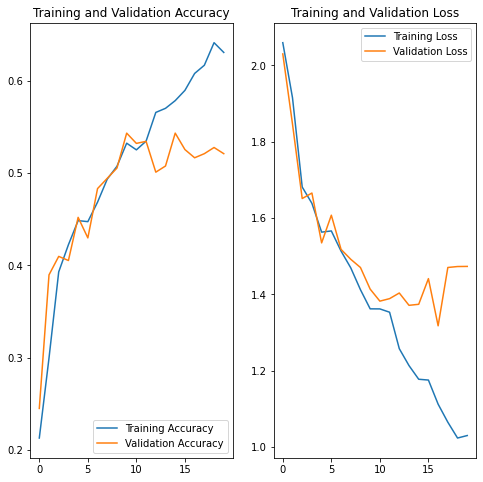

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Key Observations

- Validation Accuracy is much lesser than Training accuracy.
- The Training accuracy is around 63%
- The Validation accuracy is around 52% and tending downwards
- The training accuracy increases with increase in epochs.
- But validation accuracy seems to be stable and obviously decreases with increase in epochs as model may tend to overfit.
- Validation loss and training loss seems to be same till 10 epochs approx and then validation loss increases and training loss further decreases with increase in epochs which is expected.

In [ ]:
# Lets check how images are distributed in different classed in training dataset
for i in range(len(class_names)):
  class_name = class_names[i]
  count = str(len(list(train_dir.glob(class_names[i] + '/*.jpg'))))
  print(class_name + " - " + count)

actinic keratosis - 114
basal cell carcinoma - 376
dermatofibroma - 95
melanoma - 438
nevus - 357
pigmented benign keratosis - 471
seborrheic keratosis - 77
squamous cell carcinoma - 181
vascular lesion - 139


In [ ]:
# Lets check how images are distributed in different classed in test dataset
for i in range(len(class_names)):
  class_name= class_names[i]
  count = str(len(list(test_dir.glob(class_names[i]+'/*.jpg'))))
  print(class_name + " - " + count)


actinic keratosis - 16
basal cell carcinoma - 16
dermatofibroma - 16
melanoma - 16
nevus - 16
pigmented benign keratosis - 16
seborrheic keratosis - 3
squamous cell carcinoma - 16
vascular lesion - 3


In [ ]:
# After you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy. 

data_augmentation = tf.keras.Sequential([
                                          layers.experimental.preprocessing.RandomFlip(mode="horizontal_and_vertical"),
                                          layers.experimental.preprocessing.RandomRotation(0.2)
])

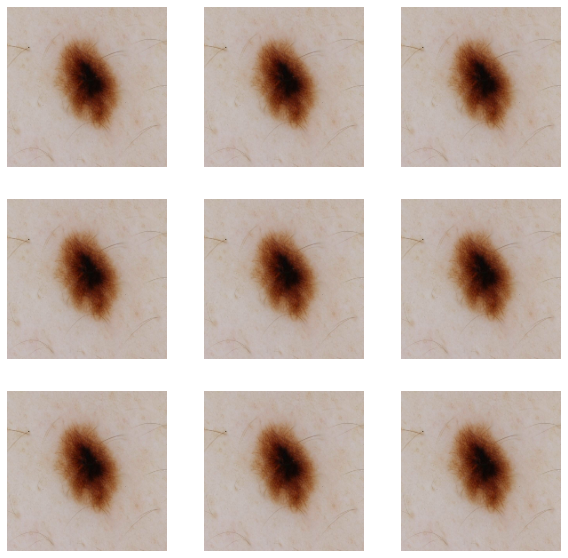

In [ ]:
# Visualize how your augmentation strategy works for one instance of training image.
image, label = next(iter(train_ds))
image = np.array(image ,np.int32)  
plt.figure(figsize=(10, 10))
for i in range(9):
  augmented_image = data_augmentation(image)
  ax = plt.subplot(3, 3, i + 1)
  augmented_image1=np.array(augmented_image[0],np.int32)  
  plt.imshow((augmented_image1))
  plt.axis("off")

### Model with Data Augumentation
### Create the model, compile and train the model


In [ ]:
## You can use Dropout layer if there is an evidence of overfitting in your findings

## code goes here
model=Sequential([data_augmentation,
                  tf.keras.layers.experimental.preprocessing.Rescaling(1/255,
                                                                       input_shape=(180, 180, 3), offset=0.0)])

model.add(Conv2D(filters=32, kernel_size= (3,3), activation='relu', padding='same', input_shape=(180, 180, 3)))
model.add(Conv2D(filters=32, kernel_size=(3,3), activation='relu', padding='same'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.2))

model.add(Conv2D(filters=32, kernel_size=(3,3), activation='relu', padding='same'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.2))

model.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding='same'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.2))

model.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding='same'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.2))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(9, activation='softmax'))


### Compiling the model

In [ ]:
##  code goes here

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

### Training the model

In [ ]:
## Your code goes here, note: train your model for 20 epochs
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
57/57 [==============================] - 6s 86ms/step - loss: 2.0262 - accuracy: 0.2129 - val_loss: 1.8719 - val_accuracy: 0.2940
Epoch 2/20
57/57 [==============================] - 5s 82ms/step - loss: 1.8454 - accuracy: 0.3218 - val_loss: 1.7368 - val_accuracy: 0.3786
Epoch 3/20
57/57 [==============================] - 5s 82ms/step - loss: 1.6826 - accuracy: 0.3769 - val_loss: 1.6581 - val_accuracy: 0.4098
Epoch 4/20
57/57 [==============================] - 5s 81ms/step - loss: 1.7443 - accuracy: 0.3452 - val_loss: 1.7865 - val_accuracy: 0.3452
Epoch 5/20
57/57 [==============================] - 5s 82ms/step - loss: 1.6854 - accuracy: 0.3785 - val_loss: 1.5828 - val_accuracy: 0.4076
Epoch 6/20
57/57 [==============================] - 5s 83ms/step - loss: 1.6172 - accuracy: 0.4275 - val_loss: 1.5992 - val_accuracy: 0.4187
Epoch 7/20
57/57 [==============================] - 5s 82ms/step - loss: 1.5386 - accuracy: 0.4553 - val_loss: 1.6756 - val_accuracy: 0.3742
Epoch 8/20
57

### Visualizing the results

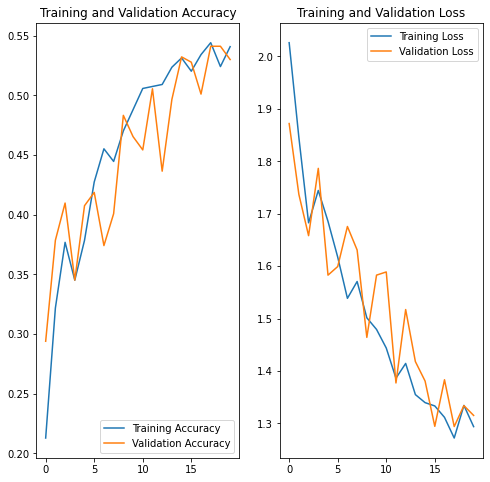

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# Observations

- The Training accuracy and validation accuracy are almost equal and follow similar trends now.
- Well the training and testing accuracy are almost equal, the problem of overfitting has been addressed with data augmentation and now both accuracies are tend to be same.
- So Now we have to deal with reduces accuracies.

#### Checking for Class Imbalance

#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [ ]:
# Lets check how images are distributed in different classed in test dataset
for i in range(len(class_names)):
  class_name= class_names[i]
  count = str(len(list(train_dir.glob(class_names[i]+'/*.jpg'))))
  print(class_name +" - "+ count)

actinic keratosis - 114
basal cell carcinoma - 376
dermatofibroma - 95
melanoma - 438
nevus - 357
pigmented benign keratosis - 471
seborrheic keratosis - 77
squamous cell carcinoma - 181
vascular lesion - 139


The training dataset the distribution of images are uneven.

- seborrheic keratosis - 77
- squamous cell carcinoma - 181
- vascular lesion - 139
- actinic keratosis - 114


Samples above cases are very less in comparison to the other cases. we need to increase the samples in each case.

## Augmentor for addressing class imbalance problem

#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [ ]:
!pip install Augmentor

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# imporitng Augmentor library
import Augmentor

In [ ]:
# checkng the path 
for i in class_names:
  print(str(train_path) +'/'+ i)

/content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis
/content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma
/content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma
/content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma
/content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus
/content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis
/content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis
/content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma
/content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion


In [ ]:
path_to_training_dataset= str(train_path)
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + '/' + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F7EBE449310>: 100%|██████████| 500/500 [00:18<00:00, 27.75 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F7EBF1FE1C0>: 100%|██████████| 500/500 [00:19<00:00, 26.30 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F7EBB72F550>: 100%|██████████| 500/500 [00:20<00:00, 24.68 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7F7EBED77BB0>: 100%|██████████| 500/500 [01:32<00:00,  5.42 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=824x719 at 0x7F7EB9D27CA0>: 100%|██████████| 500/500 [01:24<00:00,  5.93 Samples/s]


Initialised with 471 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F7EB9C38F10>: 100%|██████████| 500/500 [00:18<00:00, 27.12 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7F7EBE4F1430>: 100%|██████████| 500/500 [00:40<00:00, 12.20 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F7EBE3C0460>: 100%|██████████| 500/500 [00:17<00:00, 27.79 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F7EBEF71D90>: 100%|██████████| 500/500 [00:17<00:00, 27.99 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [ ]:
from glob import glob

In [ ]:
# checking the total count of train images
image_count_train = len(list(train_dir.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [ ]:
path_list = [x for x in glob(os.path.join(train_dir, '*','output', '*.jpg'))]
path_list

['/content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0031759.jpg_b30cc34f-0bc7-4934-a962-04234a038bd2.jpg',
 '/content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0027385.jpg_8bf6ec30-6897-4015-806f-23ebcfea4082.jpg',
 '/content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0026490.jpg_8e799bf7-f09f-49e7-9c37-74cfb6629e26.jpg',
 '/content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0033254.jpg_815a453f-5e77-4d35-99d5-2a2a852a0065.jpg',
 '/content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0028680.jpg_4dd50a5f-ccf9-4bd2-a58e-f9e258ebc

In [ ]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(train_dir, '*','output', '*.jpg'))]
lesion_list_new

['vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',


In [ ]:
dataframe_dict_new = dict(zip(path_list, lesion_list_new))

In [ ]:
len(dataframe_dict_new )

4500

In [ ]:

for i in class_names:
    directory = str(train_path)
    directory_out = str(train_path) + '/' + i +'/output/'
    class_directory = pathlib.Path(directory)
    class_directory_out = pathlib.Path(directory_out)
    length = len(list(class_directory.glob(i + '/*.jpg')))
    length_out = len(list(class_directory_out.glob('*.jpg')))
    length_total = length + length_out
    print(f'{i} has {length_total} samples.')

actinic keratosis has 614 samples.
basal cell carcinoma has 876 samples.
dermatofibroma has 595 samples.
melanoma has 938 samples.
nevus has 857 samples.
pigmented benign keratosis has 971 samples.
seborrheic keratosis has 577 samples.
squamous cell carcinoma has 681 samples.
vascular lesion has 639 samples.


So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

## Model with Augmented Data

In [ ]:
batch_size = 32
img_height = 180
img_width = 180

### Create a training dataset

In [ ]:
data_dir_train=train_path
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'training',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6748 files belonging to 9 classes.
Using 5399 files for training.


### Create a validation dataset

In [ ]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6748 files belonging to 9 classes.
Using 1349 files for validation.


### Create your model

In [ ]:
##  code goes here
model=Sequential([tf.keras.layers.experimental.preprocessing.Rescaling(1/255,
                                                                       input_shape = (180, 180 ,3),
                                                                       offset = 0.0)])

model.add(Conv2D(filters = 32, kernel_size = (3,3), activation = 'relu', padding = 'same', input_shape = (180, 180, 3)))
model.add(Conv2D(filters = 32, kernel_size = (3,3), activation = 'relu', padding = 'same'))
model.add(MaxPool2D(pool_size = (2,2)))
model.add(Dropout(0.2))

model.add(Conv2D(filters = 32,kernel_size = (3,3),activation = 'relu', padding = 'same'))
model.add(MaxPool2D(pool_size = (2,2)))
model.add(Dropout(0.2))

model.add(Conv2D(filters = 64,kernel_size = (3,3), activation = 'relu', padding = 'same'))
model.add(MaxPool2D(pool_size = (2,2)))
model.add(Dropout(0.2))

model.add(Conv2D(filters = 64, kernel_size = (3,3), activation = 'relu', padding = 'same'))
model.add(MaxPool2D(pool_size =( 2,2)))
model.add(Dropout(0.2))

model.add(Flatten())
model.add(Dense(128, activation = 'relu'))
model.add(Dropout(0.2))

model.add(Dense(9, activation = 'softmax'))

### Compile your model (Choose optimizer and loss function appropriately)

In [ ]:
##  code goes here
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

### Train your model

In [ ]:
epochs = 50
## Your code goes here, use 50 epochs.
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/50


/usr/local/lib/python3.8/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


169/169 [==============================] - 36s 207ms/step - loss: 2.0791 - accuracy: 0.1837 - val_loss: 1.8884 - val_accuracy: 0.2772
Epoch 2/50
169/169 [==============================] - 35s 199ms/step - loss: 1.8052 - accuracy: 0.2878 - val_loss: 1.7420 - val_accuracy: 0.3099
Epoch 3/50
169/169 [==============================] - 35s 198ms/step - loss: 1.6664 - accuracy: 0.3540 - val_loss: 1.5527 - val_accuracy: 0.3944
Epoch 4/50
169/169 [==============================] - 35s 199ms/step - loss: 1.4970 - accuracy: 0.4423 - val_loss: 1.3502 - val_accuracy: 0.4915
Epoch 5/50
169/169 [==============================] - 35s 198ms/step - loss: 1.3134 - accuracy: 0.5034 - val_loss: 1.2459 - val_accuracy: 0.5226
Epoch 6/50
169/169 [==============================] - 35s 198ms/step - loss: 1.1824 - accuracy: 0.5464 - val_loss: 1.1473 - val_accuracy: 0.5634
Epoch 7/50
169/169 [==============================] - 34s 197ms/step - loss: 1.0492 - accuracy: 0.6034 - val_loss: 1.0167 - val_accuracy: 0.6

###  Visualize the model results

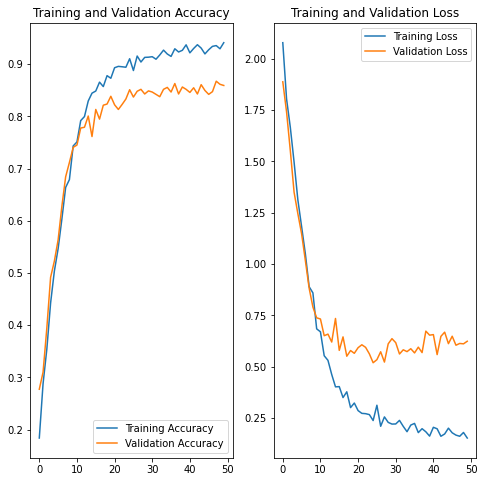

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Conclusion

- Accuracy of training set is around 94%
- The Accuracy of validation dats set is around 85%
- We may run extra epochs to see if the model performs better. But, in such case there could be a problem of overfitting as well.
- The model with the above accuracy shows an increased performace of the model when we train with dataset where number of images in each class is balanced.
- We can see that the model performed better on augmented data.
- After 10 epochs validation loss tends to slight increase and traning loss was decrease 